# Expectation-maximization algorithm

In this assignment, we will derive and implement formulas for Gaussian Mixture Model — one of the most commonly used methods for performing soft clustering of the data. 

### Installation

We will need ```numpy```, ```scikit-learn```, ```matplotlib``` libraries for this assignment

In [4]:
!conda install -y requests

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /Users/adamcox/miniconda2/envs/bayescourse:

The following NEW packages will be INSTALLED:

    asn1crypto:   0.24.0-py36_0        
    cffi:         1.11.5-py36h342bebf_0
    chardet:      3.0.4-py36h96c241c_1 
    cryptography: 2.2.2-py36h1de35cc_0 
    idna:         2.6-py36h8628d0a_1   
    pycparser:    2.18-py36h724b2fc_1  
    pyopenssl:    17.5.0-py36h51e4350_0
    pysocks:      1.6.8-py36_0         
    requests:     2.18.4-py36h4516966_1
    urllib3:      1.22-py36h68b9469_0  

cryptography-2 100% |################################| Time: 0:00:00   2.32 MB/s


In [589]:
import numpy as np
from numpy.linalg import slogdet, det, solve
import matplotlib.pyplot as plt

import time
from sklearn.datasets import load_digits
from grader import Grader
%matplotlib inline

### Grading
We will create a grader instance below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to the platform only after running submitting function in the last part of this assignment. If you want to make a partial submission, you can run that cell anytime you want.

In [590]:
grader = Grader()

## Implementing EM for GMM

For debugging we will use samples from gaussian mixture model with unknown mean, variance and priors. We also added inital values of parameters for grading purposes.

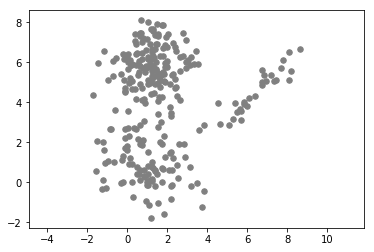

In [591]:
samples = np.load('samples.npz')
X = samples['data']
pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='grey', s=30)
plt.axis('equal')
plt.show()

In [592]:
xx = X[np.random.randint(0,X.shape[0],size=int(X.shape[0]/3)),:]
print(xx.shape)
np.cov(xx.T)

(93, 2)


array([[5.90096725, 1.11952236],
       [1.11952236, 6.19660175]])

In [593]:
samples.keys()

['mu0', 'pi0', 'data', 'sigma0']

In [594]:
X.shape

(280, 2)

In [595]:
pi0

array([0.3451814 , 0.6066179 , 0.04820071])

In [596]:
mu0.shape

(3, 2)

In [597]:
sigma0

array([[[ 1.00490413,  1.89980228],
        [ 1.89980228,  4.18354574]],

       [[ 1.96867815,  0.78415336],
        [ 0.78415336,  1.83319942]],

       [[ 0.19316335, -0.11648642],
        [-0.11648642,  1.98395967]]])

### Reminder

Remember, that EM algorithm is a coordinate descent optimization of variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{P(X, T|\theta)}{q(T)}dT\to \max$.

<b>E-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{q} \Leftrightarrow \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] \to \min \limits_{q\in Q} \Rightarrow q(T) = p(T|X, \theta)$<br>
<b>M-step</b>:<br> 
$\mathcal{L}(\theta, q) \to \max\limits_{\theta} \Leftrightarrow \mathbb{E}_{q(T)}\log p(X,T | \theta) \to \max\limits_{\theta}$

For GMM, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned. $T_i$ (cluster index for object $i$) is a binary vector with only one active bit in position corresponding to the true component. For example, if we have $C=3$ components and object $i$ lies in first component, $T_i = [1, 0, 0]$.

The joint distribution can be written as follows: $p(T, X \mid \theta) =  \prod\limits_{i=1}^N p(T_i, X_i \mid \theta) = \prod\limits_{i=1}^N \prod\limits_{c=1}^C [\pi_c \mathcal{N}(X_i \mid \mu_c, \Sigma_c)]^{T_{ic}}$.

### E-step
In this step we need to estimate the posterior distribution over the latent variables with fixed values of parameters: $q(T) = p(T|X, \theta)$. We will assume that $T_i$ (cluster index for object $i$) is a binary vector with only one '1' in position corresponding to the true component. To do so we need to compute $\gamma_{ic} = P(T_{ic} = 1 \mid X, \theta)$. Note that $\sum\limits_{c=1}^C\gamma_{ic}=1$.


<b>Important trick 1:</b> It is important to avoid numerical errors. At some point you will have to compute the formula of the following form: $\frac{e^{x_i}}{\sum_j e^{x_j}}$. When you compute exponents of large numbers, you get huge numerical errors (some numbers will simply become infinity). You can avoid this by dividing numerator and denominator by $e^{\max(x)}$: $\frac{e^{x_i-\max(x)}}{\sum_j e^{x_j - \max(x)}}$. After this transformation maximum value in the denominator will be equal to one. All other terms will contribute smaller values. This trick is called log-sum-exp. So, to compute desired formula you first subtract maximum value from each component in vector $X$ and then compute everything else as before.

<b>Important trick 2:</b> You will probably need to compute formula of the form $A^{-1}x$ at some point. You would normally inverse $A$ and then multiply it by $x$. A bit faster and more numerically accurate way to do this is to solve the equation $Ay = x$. Its solution is $y=A^{-1}x$, but the equation $Ay = x$ can be solved by Gaussian elimination procedure. You can use ```np.linalg.solve``` for this.

<b>Other usefull functions: </b> <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.slogdet.html">```slogdet```</a> and <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.det.html#numpy.linalg.det">```det```</a>

<b>Task 1:</b> Implement E-step for GMM using template below.

In [598]:
from scipy.stats import multivariate_normal


def my_multivariate_normal(x, mean, cov):
    # only works for x = a 1d array
    xx = x - mean
    d = x.shape[-1]
    return ((2*np.pi)**-d/2.) * (det(cov)**-0.5) * np.exp(-0.5*( np.dot(xx.T, np.linalg.solve(cov, xx)))) 

def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T)

    ### YOUR CODE HERE
    
    #there's certainly a way to do this without for-loops
    for n in range(N):
        for c in range(C):
            #xrow = X[n,:] - np.max(X[n,:])
            xrow = X[n,:]
            #print(xrow)
            #print(np.max(xrow))
            #print(xrow - np.max(xrow))
            #xrow = xrow[np.newaxis,:]
            #print(xrow.shape)
            #print(sigma[c,:,:].shape)
            #gamma[n,c] = pi[c]* my_multivariate_normal(xrow, mu[c], sigma[c,:,:])
            gamma[n,c] = pi[c]*multivariate_normal.pdf(xrow, mean = mu[c], cov=sigma[c,:,:])
    
       
    #now need to normalize gamma[n,c]
    gamma = gamma / np.sum(gamma, axis=1)[:, np.newaxis]  #this [:, np.newaxis] term 
        
    return gamma

In [599]:
xx = X - mu[0]
np.linalg.solve(sigma0[0,:,:], xx.T).shape

(2, 280)

In [600]:
sigma[0,:,:]

array([[3.66251522, 0.4966314 ],
       [0.4966314 , 6.04389122]])

In [601]:
pdfx = my_multivariate_normal(X[10,:], mu[0], sigma[0,:,:])

In [602]:
pdfx

0.0010631487828468204

In [603]:
gamma = E_step(X, pi0, mu0, sigma0)
grader.submit_e_step(gamma)

Current answer for task Task 1 (E-step) is: 0.5337178741081263


In [175]:
gamma.sum()

280.0

In [176]:
gamma.sum(axis=0)

array([ 23.46798135, 241.38191992,  15.15009873])

### M-step

In M-step we need to maximize $\mathbb{E}_{q(T)}\log p(X,T | \theta)$ with respect to $\theta$. In our model this means that we need to find optimal values of $\pi$, $\mu$, $\Sigma$. To do so, you need to compute the derivatives and 
set them to zero. You should start by deriving formulas for $\mu$ as it is the easiest part. Then move on to $\Sigma$. Here it is crucial to optimize function w.r.t. to $\Lambda = \Sigma^{-1}$ and then inverse obtained result. Finaly, to compute $\pi$, you will need <a href="https://www3.nd.edu/~jstiver/FIN360/Constrained%20Optimization.pdf">Lagrange Multipliers technique</a> to satisfy constraint $\sum\limits_{i=1}^{n}\pi_i = 1$.

<br>
<b>Important note:</b> You will need to compute derivatives of scalars with respect to matrices. To refresh this technique from previous courses, see <a href="https://en.wikipedia.org/wiki/Matrix_calculus"> wiki article</a> about it . Main formulas of matrix derivatives can be found in <a href="http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf">Chapter 2 of The Matrix Cookbook</a>. For example, there you may find that $\frac{\partial}{\partial A}\log |A| = A^{-T}$.


<b>Task 2:</b> Implement M-step for GMM using template below.

In [192]:
mu = np.dot(gamma.T, X)

In [194]:
mu.shape

(3, 2)

In [195]:
mu

array([[  50.68968134,   33.19292417],
       [ 360.35846131, 1065.32652211],
       [  54.94639267,   26.33300995]])

In [191]:
gamma.sum(axis=0).reshape(-1,1)

array([[ 23.46798135],
       [241.38191992],
       [ 15.15009873]])

In [197]:
mu = np.dot(gamma.T, X)
print(mu)
print(gamma.sum(axis=0)[:,np.newaxis])
mu = np.divide(mu,gamma.sum(axis=0).reshape(-1,1))
print(mu)

[[  50.68968134   33.19292417]
 [ 360.35846131 1065.32652211]
 [  54.94639267   26.33300995]]
[[ 23.46798135]
 [241.38191992]
 [ 15.15009873]]
[[2.15995064 1.41439196]
 [1.49289749 4.41344788]
 [3.62680096 1.73814114]]


In [203]:
diff = X - mu[0]
np.dot(diff.T, diff).shape

(2, 2)

In [207]:
x1 = np.arange(6.0).reshape((3, 2))
x2 = np.arange(3.0).reshape((3,1))

print(x1)
print(x2)
np.multiply(x1, x2)

[[0. 1.]
 [2. 3.]
 [4. 5.]]
[[0.]
 [1.]
 [2.]]


array([[ 0.,  0.],
       [ 2.,  3.],
       [ 8., 10.]])

In [215]:
X

array([[ 1.17228095e+00,  5.75213236e+00],
       [ 1.05443001e+00,  5.10029341e+00],
       [ 1.21814807e+00,  5.15920217e+00],
       [ 1.75362297e+00,  7.88315382e+00],
       [ 2.05005447e+00,  7.38909041e+00],
       [ 2.20779501e+00,  3.44969157e+00],
       [ 5.29273819e+00,  3.15319415e+00],
       [ 3.79661006e-02,  6.00430278e+00],
       [ 7.17431136e-01,  6.13701974e+00],
       [-1.18307081e+00,  1.58755199e+00],
       [-8.17944961e-01,  2.63902188e+00],
       [ 1.21663018e+00,  5.58031550e+00],
       [-2.54147644e-01,  1.10080559e+00],
       [ 3.02128295e+00,  6.09120151e+00],
       [ 2.48589386e+00,  4.31904544e+00],
       [ 6.06880749e-02,  3.54822919e+00],
       [ 1.37942797e+00, -1.69794694e-01],
       [ 1.53537865e+00,  7.41921097e+00],
       [-2.07335270e-01,  1.30016067e+00],
       [ 3.14906787e+00,  5.85690104e+00],
       [ 2.44103605e-01,  4.66387340e+00],
       [ 5.36539238e+00,  3.95180149e+00],
       [ 7.30859440e-01,  7.00801146e+00],
       [ 1.

In [216]:
gamma[:,1]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.98540731, 0.70012896, 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99364669, 1.        , 0.99989698,
       1.        , 0.61126479, 1.        , 0.99811911, 0.99999999,
       1.        , 0.58339716, 1.        , 1.        , 0.99999994,
       1.        , 0.85114896, 1.        , 1.        , 0.99999801,
       0.99999991, 0.44652749, 0.40367352, 0.75664228, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999954,
       0.6421527 , 0.56043234, 0.40505999, 1.        , 0.44796917,
       1.        , 0.67038353, 1.        , 1.        , 1.        ,
       1.        , 0.40664949, 0.50665808, 0.71294586, 1.        ,
       0.4309033 , 0.66731561, 1.        , 0.99989037, 0.99258051,
       0.43072152, 1.        , 0.99999353, 1.        , 1.        ,
       1.        , 0.99999799, 0.49610888, 0.47040807, 1.        ,
       1.        , 1.        , 1.        , 0.71048733, 0.52776

In [223]:
np.multiply(gamma[:,1].reshape(-1,1), X).T.dot(X)

array([[1337.33334069, 1715.10139367],
       [1715.10139367, 6023.3386793 ]])

In [391]:
N_k = np.sum(gamma, axis=0)

In [393]:
N_k/X.shape[0]

array([0.44702322, 0.55076245, 0.00221433])

In [609]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    ### YOUR CODE HERE
    N_k = np.sum(gamma, axis=0)
    mu = np.divide(np.dot(gamma.T, X),gamma.sum(axis=0)[:,np.newaxis])
    sigma = np.zeros((C,d,d),dtype=np.float)
    for c in range(C):
        diff = X - mu[c]
        sigma[c,:,:] = np.multiply(gamma[:,c].reshape(-1,1), diff).T.dot(diff)/N_k[c]

    pi = N_k / N
    return pi, mu, sigma

In [610]:
gamma = E_step(X, pi0, mu0, sigma0)
pi, mu, sigma = M_step(X, gamma)
grader.submit_m_step(pi, mu, sigma)
print(pi)
print(mu)
print(sigma)

Current answer for task Task 2 (M-step: mu) is: 2.8993918820503817
Current answer for task Task 2 (M-step: sigma) is: 5.9771052168975265
Current answer for task Task 2 (M-step: pi) is: 0.5507624459218776
[0.44702322 0.55076245 0.00221433]
[[ 1.05852748  5.40759435]
 [ 2.16796132  2.89939188]
 [-1.33306197  1.41522785]]
[[[ 0.70631457  1.00189734]
  [ 1.00189734  3.09525744]]

 [[ 5.76353448  1.49049001]
  [ 1.49049001  5.97710522]]

 [[ 0.0676037  -0.21186747]
  [-0.21186747  3.29922798]]]


In [611]:
def M_step2(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object
    pi = np.zeros(C)
    mu = np.zeros((C, d))
    sigma = np.zeros((C, d, d))
    for k in range(C):
        q_sum = gamma[:,k].sum()
        mu[k,:] = (X*gamma[:,k][:, np.newaxis]).sum(axis=0)/ q_sum
        sigma[k,:] = np.sum([gamma[i,k] * np.outer(X[i] - mu[k], X[i] - mu[k]) for i in range(N)], axis=0) / q_sum
        pi[k] = q_sum / N

    return pi, mu, sigma

In [613]:
gamma = E_step(X, pi0, mu0, sigma0)
pi, mu, sigma = M_step2(X, gamma)
grader.submit_m_step(pi, mu, sigma)
print(pi)
print(mu)
print(sigma)

Current answer for task Task 2 (M-step: mu) is: 2.899391882050384
Current answer for task Task 2 (M-step: sigma) is: 5.9771052168975265
Current answer for task Task 2 (M-step: pi) is: 0.5507624459218775
[0.44702322 0.55076245 0.00221433]
[[ 1.05852748  5.40759435]
 [ 2.16796132  2.89939188]
 [-1.33306197  1.41522785]]
[[[ 0.70631457  1.00189734]
  [ 1.00189734  3.09525744]]

 [[ 5.76353448  1.49049001]
  [ 1.49049001  5.97710522]]

 [[ 0.0676037  -0.21186747]
  [-0.21186747  3.29922798]]]


In [416]:
gamma[:,0].reshape(-1,1).shape


(280, 1)

### Loss function

Finally, we need some function to track convergence. We will use variational lower bound $\mathcal{L}$ for this purpose. We will stop our EM iterations when $\mathcal{L}$ will saturate. Usually, you will need only about 10-20 iterations to converge. It is also useful to check that this function never decreases during training. If it does, you have a bug in your code.

<b>Task 3:</b> Implement a function that will compute $\mathcal{L}$ using template below.

$$\mathcal{L} = \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] (\log \pi_k + \log \mathcal{N}(x_n | \mu_k, \sigma_k)) - \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] \log \mathbb{E}[z_{n, k}]$$

In [777]:
def compute_vlb(X, pi, mu, sigma, gamma, mvn = multivariate_normal.pdf):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    mvn = multivariate_normal_pdf function
        either use scipy, or my implementation
        
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    ### YOUR CODE HERE
    loss = 0
    for c in range(C):
        try:
            #probX = multivariate_normal.pdf(X, mean = mu[c], cov=sigma[c,:,:])
            probX = mvn(X, mean = mu[c], cov=sigma[c,:,:])
            #print(probX)
            val = np.dot(gamma[:,c],np.log(probX+1.0e-13) + np.log(pi[c]+1.0e-13))
            #print(val)
            loss +=  val
        except ValueError as e:
            print(e)
            print(sigma)
            print(sigma[c,:,:])
            raise e
            
    loss -= np.multiply(gamma, np.log(gamma+1e-13)).sum()

    return loss

In [684]:
a = np.array([[1,2],[3,4]])

In [685]:
a

array([[1, 2],
       [3, 4]])

In [686]:
a.T

array([[1, 3],
       [2, 4]])

In [690]:
a.dot(a.T)

array([[ 5, 11],
       [11, 25]])

In [678]:
np.multiply(a,np.log(a)).sum()

45.235564744595834

In [681]:
np.dot(a.T, np.log(a))

array([[19.16654849, 21.68698962],
       [22.498753  , 26.06901626]])

In [651]:
-np.multiply(gamma, np.log(gamma+1e-9)).sum()

65.96911873779648

In [666]:
gamma.shape

(280, 3)

In [462]:
mu

array([[ 1.05852748,  5.40759435],
       [ 2.16796132,  2.89939188],
       [-1.33306197,  1.41522785]])

In [463]:
sigma

array([[[ 0.70631457,  1.00189734],
        [ 1.00189734,  3.09525744]],

       [[ 5.76353448,  1.49049001],
        [ 1.49049001,  5.97710522]],

       [[ 0.0676037 , -0.21186747],
        [-0.21186747,  3.29922798]]])

In [464]:
pi

array([0.44702322, 0.55076245, 0.00221433])

In [465]:
c = 2
(np.dot(gamma[:,c],np.log(multivariate_normal.pdf(X-X.max(axis=0), mean = mu[c], cov=sigma[c,:,:])+0.00001) + np.log(pi[c]+0.00001)))
#(np.dot(gamma,np.log(multivariate_normal.pdf(X, mean = mu, cov=sigma)) + np.log(pi)))

-10.925387585498541

In [767]:
loss

1150.5132630339047

In [778]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
grader.submit_VLB(loss)


Current answer for task Task 3 (VLB) is: -1213.973437451592


In [764]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
print(pi, mu, sigma , loss)

[0.46383545 0.52768499 0.00847956] [[ 1.07499213  5.85685648]
 [ 2.22864219  2.45133965]
 [-1.22344612  0.84643644]] [[[ 0.68405518  0.17863387]
  [ 0.17863387  1.3030211 ]]

 [[ 5.86816538  2.66859884]
  [ 2.66859884  5.09531312]]

 [[ 0.02252806 -0.06231391]
  [-0.06231391  0.97861765]]] 1150.5132630339047


In [505]:
sigma0

array([[[3.7052961 , 0.47317406],
        [0.47317406, 5.95373982]],

       [[3.23074395, 0.14994485],
        [0.14994485, 5.12252562]],

       [[4.14966413, 0.80463019],
        [0.80463019, 6.54800119]]])

### Bringing it all together

Now that we have E step, M step and VLB, we can implement training loop. We will start at random values of $\pi$, $\mu$ and $\Sigma$, train until $\mathcal{L}$ stops changing and return the resulting points. We also know that EM algorithm sometimes stops at local optima. To avoid this we should restart algorithm multiple times from different starting positions. Each training trial should stop either when maximum number of iterations is reached or when relative improvement is smaller than given tolerance ($|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal{L}_{i-1}}| \le \text{rtol}$).

Remember, that values of $\pi$ that you generate must be non-negative and sum up to 1. Also, $\Sigma$ matrices must be symmetric and positive semi-definite. If you don't know how to generate those matrices, you can use $\Sigma=I$ as initialization.

You will also sometimes get numerical errors because of component collapsing. The easiest way to deal with this problems is to simply restart the procedure.

<b>Task 4:</b> Implement training procedure

In [452]:
X.max(axis=0)

array([8.62533136, 8.08548733])

In [453]:
pi0 = np.random.randn(3,2)*X.max(axis=0)/1.5
print(pi0)
print(pi0.sum())

[[-2.63390585 -6.68593365]
 [-1.67585513  3.31208141]
 [-6.26770647 -3.93645941]]
-17.88777910933173


In [454]:
sigma0 = np.zeros((10,2,2), dtype=np.float)

In [455]:
sigma0[0,:,:]

array([[0., 0.],
       [0., 0.]])

In [497]:
C,d  = 3,2

sigma_ = np.random.rand(C, d, d)
print(sigma_)
sigma = np.array([np.dot(A, A.T) for A in sigma_])
sigma

[[[0.85269356 0.80625096]
  [0.76757971 0.2579088 ]]

 [[0.17917993 0.31599937]
  [0.08684136 0.68370508]]

 [[0.6261453  0.65986771]
  [0.84791466 0.52690943]]]


array([[[1.37712691, 0.86244949],
        [0.86244949, 0.65569556]],

       [[0.13196105, 0.2316106 ],
        [0.2316106 , 0.47499406]],

       [[0.82748333, 0.87860829],
        [0.87860829, 0.99659281]]])

In [509]:
sigma0 = np.zeros((C,d,d), dtype=np.float)
for c in range(C):
    sigma0[c,:,:] = np.cov(X[np.random.randint(0,X.shape[0],size=int(X.shape[0]/3)),:].T)
    
print(sigma0)
print(sigma0.sum(axis=1).sum(axis=1))
print(sigma0/sigma0.sum(axis=1).sum(axis=1)[:,np.newaxis,np.newaxis])


[[[3.4961043  1.27408894]
  [1.27408894 5.6830558 ]]

 [[6.56120847 1.18371909]
  [1.18371909 5.48737927]]

 [[2.3791707  0.67255181]
  [0.67255181 6.10281444]]]
[11.72733798 14.41602593  9.82708876]
[[[0.29811576 0.10864264]
  [0.10864264 0.48459896]]

 [[0.45513295 0.08211133]
  [0.08211133 0.38064438]]

 [[0.24210331 0.06843856]
  [0.06843856 0.62101957]]]


In [782]:
def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None

    for _ in range(restarts):
        
        print("\n New Run \n\n")
        try:
            ### YOUR CODE HERE
            last_loss = None
            numiter = 0
            
            
            pi = np.random.rand(3)
            pi = pi0/pi0.sum()
            #print(pi)
            #mu = np.random.randn(3,2)*X.mean()
            #print(mu)
            sigma = np.zeros((C,d,d), dtype=np.float)
            for c in range(C):
                sigma[c,:,:] = np.cov(X[np.random.randint(0,X.shape[0],size=int(X.shape[0]/3)),:].T)

            sigma /= sigma.sum(axis=1).sum(axis=1)[:,np.newaxis,np.newaxis]
            #sigma = samples['sigma0']
    
            sigma_ = np.random.rand(C, d, d)
            sigma = np.array([np.dot(A, A.T) for A in sigma_])
            #print(sigma)
            
            
            pi = np.array([1.0/C]*C,dtype=np.float32)
            mu = np.random.rand(C, d)
            #sigma_ = np.random.rand(C, d, d)
            #sigma = np.array([np.dot(A, A.T) for A in sigma_])
            
            print('init values')
            print(pi)
            print(mu)
            print(sigma)
            
            while True:
                
                gamma = E_step(X, pi, mu, sigma)
                pi, mu, sigma = M_step(X, gamma)
                loss = -compute_vlb(X, pi, mu, sigma, gamma)
                
                print("iter{}, loss {}".format(numiter, loss))

                
                if best_loss is None or loss < best_loss:
                    best_loss = loss
                    best_pi = pi
                    best_mu = mu
                    best_sigma = sigma
                
                if last_loss is not None and loss > last_loss: 
                    raise Exception("error", "last_loss: {}, this_loss: {}".format(last_loss, loss))
                
                if (last_loss is not None) and last_loss - loss < rtol:
                    print(loss)
                    print(last_loss)
                    print("loss converged: {}".format(last_loss - loss))
                    break
                
                        
                        
                if numiter == max_iter:
                    break
                    
                numiter += 1
                last_loss = loss

        except Exception as e:
            print(e)
            pass

        print(-best_loss)
        print(best_pi)
        print(best_mu)
        print(best_sigma)
    return -best_loss, best_pi, best_mu, best_sigma

In [783]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3)
grader.submit_EM(best_loss)


 New Run 


init values
[0.33333334 0.33333334 0.33333334]
[[0.81251478 0.50173078]
 [0.22155087 0.91820349]
 [0.24355623 0.97425982]]
[[[1.0876924  0.68786154]
  [0.68786154 1.00268594]]

 [[0.36672547 0.67002781]
  [0.67002781 1.41347395]]

 [[0.09134439 0.14879352]
  [0.14879352 0.25820822]]]
iter0, loss 1281.9596919304095
iter1, loss 1227.1927293143876
iter2, loss 1210.662643316836
iter3, loss 1191.5178209949772
iter4, loss 1170.7695599037993
iter5, loss 1157.477574573195
iter6, loss 1150.8036553223785
iter7, loss 1145.952785271049
iter8, loss 1141.4540173329026
iter9, loss 1137.4630948149268
iter10, loss 1134.3661146462398
iter11, loss 1132.186574816456
iter12, loss 1130.7857134767048
iter13, loss 1129.9840115311024
iter14, loss 1129.5777632663621
iter15, loss 1129.3890384213037
iter16, loss 1129.3048197264145
iter17, loss 1129.2674393773646
iter18, loss 1129.2505840721947
iter19, loss 1129.2427490452724
iter20, loss 1129.2389434977667
iter21, loss 1129.236985772671
iter22, loss 

iter18, loss 1206.187434171692
iter19, loss 1202.7368937621197
iter20, loss 1197.2578155446997
iter21, loss 1190.3032909397898
iter22, loss 1183.4505277426474
iter23, loss 1176.5148030582097
iter24, loss 1169.728318567567
iter25, loss 1164.281109026612
iter26, loss 1161.1786671521081
iter27, loss 1159.8857231161398
iter28, loss 1159.4020069379571
iter29, loss 1159.1648604859615
iter30, loss 1158.947202894053
iter31, loss 1158.7530531748357
iter32, loss 1158.6583059546601
iter33, loss 1158.621515628318
iter34, loss 1158.5981472550234
iter35, loss 1158.571638468063
iter36, loss 1158.529069720254
iter37, loss 1158.4455684060101
iter38, loss 1158.2987368070678
iter39, loss 1158.1913528536413
iter40, loss 1158.1608075036092
iter41, loss 1158.1477186905167
iter42, loss 1158.1384758782945
iter43, loss 1158.1298008057556
iter44, loss 1158.119841060771
iter45, loss 1158.106316978367
iter46, loss 1158.0849955591584
iter47, loss 1158.046842093828
iter48, loss 1157.9707129227822
iter49, loss 1157.

iter40, loss 1104.1765265998135
iter41, loss 1101.4166061552764
iter42, loss 1097.9912160243082
iter43, loss 1093.8179190531225
iter44, loss 1089.2682538589418
iter45, loss 1084.3348632386928
iter46, loss 1079.201293245826
iter47, loss 1074.393004781878
iter48, loss 1070.3702678282586
iter49, loss 1067.404518265248
iter50, loss 1065.5711911009473
iter51, loss 1064.6225836435603
iter52, loss 1064.180387869546
iter53, loss 1063.980390426262
iter54, loss 1063.8895857696195
iter55, loss 1063.8478680232122
iter56, loss 1063.828488426787
iter57, loss 1063.8194077825096
iter58, loss 1063.8151259129527
iter59, loss 1063.8130977360438
iter60, loss 1063.8121340148696
1063.8121340148696
1063.8130977360438
loss converged: 0.0009637211742301588
-1063.811699852713
[0.10727386 0.34221837 0.55050776]
[[6.29727181 4.43163691]
 [0.92130628 0.96906964]
 [1.22331714 5.83152166]]
[[[ 1.7062103   1.3897418 ]
  [ 1.3897418   1.3215502 ]]

 [[ 1.49927144 -0.37267466]
  [-0.37267466  1.43398316]]

 [[ 0.943165

If you implemented all the steps correctly, your algorithm should converge in about 20 iterations. Let's plot the clusters to see it. We will assign a cluster label as the most probable cluster index. This can be found using matrix $\gamma$ computed on last E-step. 


In [784]:
best_loss

-1063.811699852713

In [785]:
best_pi

array([0.10727386, 0.34221837, 0.55050776])

In [786]:
best_mu

array([[6.29727181, 4.43163691],
       [0.92130628, 0.96906964],
       [1.22331714, 5.83152166]])

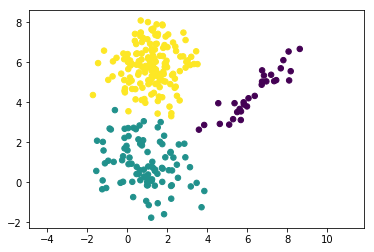

In [787]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30)
plt.axis('equal')
plt.show()

### Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and your token into variables below. You can generate the token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [788]:
grader.submit_EM(best_loss)

Current answer for task Task 4 (EM) is: -1063.811699852713


In [789]:
STUDENT_EMAIL = 'ac00@uw.edu'# EMAIL HERE
STUDENT_TOKEN = 'bKNi8FY6PLI3bf4Y'# TOKEN HERE
grader.status()

You want to submit these numbers:
Task Task 1 (E-step): 0.5337178741081263
Task Task 2 (M-step: mu): 2.899391882050384
Task Task 2 (M-step: sigma): 5.9771052168975265
Task Task 2 (M-step: pi): 0.5507624459218775
Task Task 3 (VLB): -1213.973437451592
Task Task 4 (EM): -1063.811699852713


If you want to submit these answers, run cell below

In [790]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
